## Perform a "smoke test" of YOLOv5 on COCO dataset

1. Download YOLOv5 repository from here: 
https://pytorch.org/hub/ultralytics_yolov5/

2.  Download models weights from https://github.com/ultralytics/yolov5/releases

3. Check that it work on one sample image. Examine model outputs.

4. Install pycocotools
https://github.com/cocodataset/cocoapi.git

5. Perform object detection only for bycycle class.

6. Display ground true and detected bounding boxes on images.





1. Loading dependencies

In [1]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

     |████████████████████████████████| 596 kB 4.9 MB/s 


2. Loading model

In [2]:
import torch

model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-23 torch 1.10.0+cu111 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


3. Checking model on sample image

In [3]:
# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

image 1/1: 720x1280 2 persons, 2 ties
Speed: 412.4ms pre-process, 299.1ms inference, 22.2ms NMS per image at shape (1, 3, 384, 640)
Saved 1 image to runs/detect/exp


,xmin,ymin,xmax,ymax,confidence,class,name
0,742.974792,48.395691,1141.844604,720.000000,0.881052,0,person
1,442.007660,437.522400,496.653961,709.973572,0.675214,27,tie
2,123.024200,193.287354,715.662231,719.723877,0.665813,0,person
3,982.803162,308.417358,1027.365845,419.987000,0.260076,27,tie


Model outputs are: 
* box boundaries (xmin, ymin, xmax, ymax)
* confidence in the result (confidence)
* class of the detected object (class)
* name of the class (name)

4. Loading COCO

In [4]:
import requests, zipfile, io

r = requests.get(
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [5]:
from pycocotools.coco import COCO

coco = COCO("annotations/instances_val2017.json")

loading annotations into memory...
Done (t=1.50s)
creating index...
index created!


In [6]:
from io import BytesIO
from PIL import Image

def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

In [7]:
import matplotlib.pyplot as plt

catIds = coco.getCatIds(catNms=["bicycle"])
# bicycle
imgIds = coco.getImgIds(catIds=catIds)
img_list = coco.loadImgs(imgIds[5])
img = img_list[0]

pil_img = coco2pil(img["coco_url"])
plt.figure(figsize=(10, 10))
plt.imshow(pil_img)

annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.axis('off')
plt.show()
print("Image data:")
img

http://images.cocodataset.org/val2017/000000549390.jpg
Image data:


{'coco_url': 'http://images.cocodataset.org/val2017/000000549390.jpg',
 'date_captured': '2013-11-18 04:43:33',
 'file_name': '000000549390.jpg',
 'flickr_url': 'http://farm3.staticflickr.com/2478/3980730371_4afea4ce86_z.jpg',
 'height': 427,
 'id': 549390,
 'license': 2,
 'width': 640}

5. Performing object detection only for bicycle class

In [8]:
model.classes=[1] # detecting only bicycles
results = model(pil_img)
results.print()
results.save()

print(f'\nresults.xyxy type: {type(results.xyxy)}\
\nlen(results.xyxy): {len(results.xyxy)}\
\nresults.xyxy[0].shape: {results.xyxy[0].shape}')

results.pandas().xyxy[0]

image 1/1: 427x640 4 bicycles
Speed: 5.1ms pre-process, 361.2ms inference, 4.8ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs/detect/exp2



results.xyxy type: <class 'list'>
len(results.xyxy): 1
results.xyxy[0].shape: torch.Size([4, 6])


,xmin,ymin,xmax,ymax,confidence,class,name
0,427.866882,208.830963,479.819885,258.323608,0.775313,1,bicycle
1,69.432388,239.175980,381.246948,426.703979,0.657672,1,bicycle
2,548.761230,208.338516,570.565552,237.952042,0.470246,1,bicycle
3,597.815491,220.398178,614.723572,244.010574,0.377027,1,bicycle


6. Displaying images

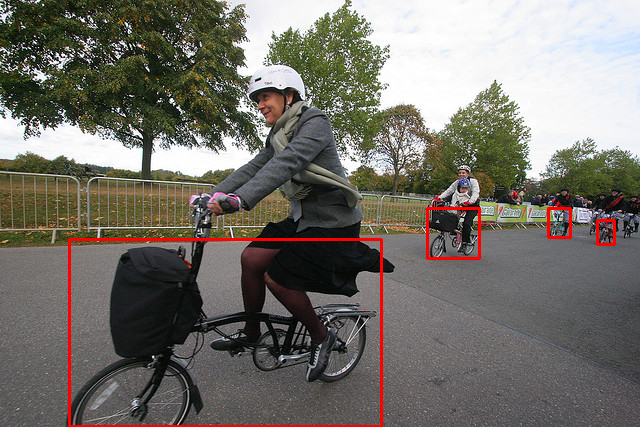

In [9]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# plot predicted results
cv_img = np.array(pil_img)
RGB_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

annos = results.pandas().xyxy[0]

for i in range(len(annos)):
    x_min, y_min, x_max, y_max = (
        int(annos["xmin"].iloc[i]),
        int(annos["ymin"].iloc[i]),
        int(annos["xmax"].iloc[i]),
        int(annos["ymax"].iloc[i]),
    )

    if annos["name"].iloc[i] == "person":
        color = (255, 255, 255)
    if annos["name"].iloc[i] == "bicycle":
        color = (0, 0, 255)
    if annos["name"].iloc[i] == "backpack":
        color = (0, 255, 0)
    RGB_img = cv2.rectangle(RGB_img, (x_min, y_min), (x_max, y_max), color, 2)
cv2_imshow(RGB_img)

## Ideas for extra work


* Calculate mAP metric for bicycle detection
* Change detector to YOLOX or another SOTA model and calculate mAP again